In [17]:
import AutoEncoders
import Utilities

from transformers import CLIPVisionModel
import torch
from torch.optim import Adam
import torch.nn.functional as F

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", str(DEVICE).upper() + ".")

Using CPU.


In [23]:
loader = Utilities.createImageDataloader(
    "Images/Square 512",
    model_name="openai/clip-vit-base-patch32",
    batch_size=64,
    shuffle=True,
    drop_last=True,
)

model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32").eval()
model.config.output_hidden_states = True
model.to(DEVICE)
CLS_LAYER = 6

SAE = AutoEncoders.OrthogonalSAE(
    input_dim     = 768,
    num_features  = 2048,
    sparsity      = 0.50,
    orthogonality = 0.10,
).to(DEVICE)

TypeError: createImageDataloader() got an unexpected keyword argument 'drop_last'

In [19]:
epochs     = 1
optimizer  = Adam(SAE.parameters(), lr=1e-3)

for epoch in range(epochs):
    SAE.train()
    rec_sum = spars_sum = ortho_sum = act_sum = 0.0
    n_batches = 0

    for images in loader:
        images = (images[0] if isinstance(images, (tuple, list)) else images).to(DEVICE)

        with torch.no_grad():
            feats = model(pixel_values=images).hidden_states[CLS_LAYER][:, 0]

        loss = SAE.loss(feats)
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        SAE.renorm()

        with torch.no_grad():
            _, f, recon = SAE.forward(feats)[:3]
            rec_sum   += F.mse_loss(recon, feats, reduction='sum').item()
            spars_sum += f.abs().sum().item()
            C         = SAE.compute_competition(f)
            ortho_sum += SAE.orthogonality * SAE.ortho_penalty(C).item()
            act_sum   += (f != 0).sum(dim=1).float().mean().item()
            n_batches += 1

    rec   = rec_sum   / n_batches
    spars = spars_sum / n_batches
    ortho = ortho_sum / n_batches
    act   = act_sum   / n_batches
    total = loss.item()

    print(f"Epoch {epoch+1:02d}/{epochs} | "
          f"Rec={rec:.4f} | L1={spars:.1f} | Ortho={ortho:.4f} | "
          f"Act={act:.1f} | LastLoss={total:.4f}")

Epoch 01/1 | Rec=604.3094 | L1=6002.2 | Ortho=59.6266 | Act=693.1 | LastLoss=555.2979


In [ ]:
DEVICE = next(model.parameters()).device

batch = next(iter(loader))
imgs  = (batch[0] if isinstance(batch, (tuple, list)) else batch).to(DEVICE)

with torch.no_grad():
    feats = model(pixel_values=imgs).hidden_states[CLS_LAYER][:, 0]
    _, z, _ = SAE(feats)

latents = z[0].cpu().numpy()

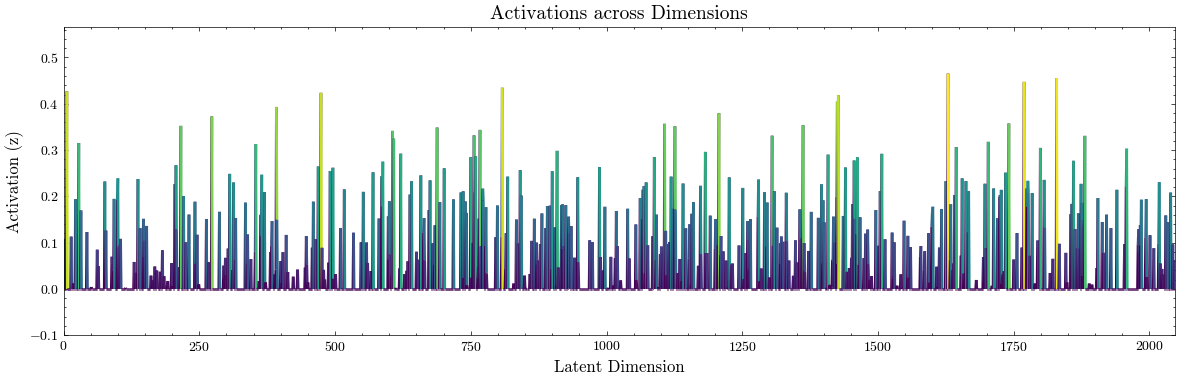

In [21]:
Utilities.plotActivation(latents)